In [1]:
import mysql.connector
import pandas as pd
import xgboost
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [2]:
# The config for the database
config = {
  'user': 'jake',
  'password': 'jake',
  'host': '127.0.0.1',
  'database': 'SportMaster',
  'raise_on_warnings': True,
}
cnx = mysql.connector.connect(**config)

In [3]:
#Personality

age = ("""SELECT 
    sm_clients.`client_reg_code`, t2.age
FROM
    sm_clients
        LEFT JOIN
    (SELECT 
        sm_clients.`CLIENT_REG_CODE`,
            TIMESTAMPDIFF(YEAR, sm_clients.birthday, '2016-10-13') AS age
    FROM
        sm_clients) t2 ON sm_clients.`CLIENT_REG_CODE` = t2.`CLIENT_REG_CODE`
WHERE
    sm_clients.client_reg_code IN (SELECT 
            sm_communication.`CLIENT_REG_CODE`
        FROM
            sm_communication
        WHERE
            sm_communication.action_code = 1693
                AND sm_communication.`STATE` = 2)
HAVING t2.age >= 14
""")


gender = ("""SELECT 
    sm_clients.client_reg_code, sm_clients.sex
FROM
    sm_clients
WHERE
    sm_clients.client_reg_code IN (SELECT 
            sm_communication.`CLIENT_REG_CODE`
        FROM
            sm_communication
        WHERE
            sm_communication.action_code = 1693
                AND sm_communication.`STATE` = 2)
""")


ismobile_isemail = ("""SELECT 
    sm_clients.client_reg_code,
    sm_clients.ismobile,
    sm_clients.isemail
FROM
    sm_clients
WHERE
    sm_clients.CLIENT_REG_CODE IN (SELECT 
            sm_communication.`CLIENT_REG_CODE`
        FROM
            sm_communication
        WHERE
            sm_communication.action_code = 1693
                AND sm_communication.`STATE` = 2)
""")

#Merge all the Personality Data
age_df = pd.read_sql_query(age, cnx)
gender_df = pd.read_sql_query(gender, cnx)
ismobile_isemail_df = pd.read_sql_query(ismobile_isemail, cnx)

Personality = age_df.merge(gender_df, how = 'left', on='client_reg_code')\
.merge(ismobile_isemail_df, how = 'left',on='client_reg_code')

In [6]:
#Geographically related

inMoscow = ("""
SELECT 
    sm_clients.client_reg_code, 1 as inMoscow
FROM
    sm_clients
WHERE
    ADDR_CITY = 'Москва';
""")


inStPetersburg = ("""
SELECT 
    sm_clients.client_reg_code, 1 as inStPetersburg
FROM
    sm_clients
WHERE
    ADDR_CITY = 'Санкт-Петербург';
"""
)


avgVisitors = ("""
SELECT 
    sm_clients.`client_reg_code`, t2.AVGVisitors
FROM
    sm_clients
        LEFT JOIN
    (SELECT 
        sm_shops_visitors.shop,
            AVG(sm_shops_visitors.visitors) AS AVGVisitors
    FROM
        sm_shops_visitors
    GROUP BY sm_shops_visitors.shop) t2 ON sm_clients.place_shop = t2.shop
WHERE
    sm_clients.client_reg_code IN (SELECT 
            sm_communication.`CLIENT_REG_CODE`
        FROM
            sm_communication
        WHERE
            sm_communication.action_code = 1693
                AND sm_communication.`STATE` = 2)
""")


registerSQT_registerSQTtrade = ("""
SELECT 
    sm_clients.client_reg_code,
    t2.RegisterSQT,
    t2.Register_SQT_trade
FROM
    sm_clients
        LEFT JOIN
    (SELECT 
        sm_shops_sprav.shop,
            sm_shops_sprav.SQT AS RegisterSQT,
            sm_shops_sprav.SQT_trade AS Register_SQT_trade
    FROM
        sm_shops_sprav) t2 ON sm_clients.place_shop = t2.shop
WHERE
    sm_clients.client_reg_code IN (SELECT 
            sm_communication.`CLIENT_REG_CODE`
        FROM
            sm_communication
        WHERE
            sm_communication.action_code = 1693
                AND sm_communication.`STATE` = 2)
""")


avgVisitorsBetweenPromotion = ("""
SELECT 
    sm_clients.client_reg_code, t2.AVGVisitorsBetweenPromotion
FROM
    sm_clients
        LEFT JOIN
    (SELECT 
        sm_shops_visitors.shop,
            AVG(sm_shops_visitors.visitors) AS AVGVisitorsBetweenPromotion
    FROM
        sm_shops_visitors
    WHERE
        dat BETWEEN '28.08.2014' AND '31.08.2014'
    GROUP BY sm_shops_visitors.shop) t2 ON sm_clients.place_shop = t2.shop
WHERE
    sm_clients.client_reg_code IN (SELECT 
            sm_communication.`CLIENT_REG_CODE`
        FROM
            sm_communication
        WHERE
            sm_communication.action_code = 1693
                AND sm_communication.`STATE` = 2)
HAVING t2.AVGVisitorsBetweenPromotion IS NOT NULL
""")

#Merge all the Personality Data
inMoscow_df = pd.read_sql_query(inMoscow, cnx)
inStPetersburg_df = pd.read_sql_query(inStPetersburg, cnx)
avgVisitors_df = pd.read_sql_query(avgVisitors, cnx)
registerSQT_registerSQTtrade_df = pd.read_sql_query(registerSQT_registerSQTtrade, cnx)
avgVisitorsBetweenPromotion_df = pd.read_sql_query(avgVisitorsBetweenPromotion, cnx)


Geographically = Personality\
.merge(inMoscow_df, how = 'left', on='client_reg_code')\
.merge(inStPetersburg_df, how = 'left', on='client_reg_code')\
.merge(avgVisitors_df, how = 'left',on='client_reg_code')\
.merge(registerSQT_registerSQTtrade_df, how = 'left',on='client_reg_code')\
.merge(avgVisitorsBetweenPromotion_df, how = 'left',on='client_reg_code')


In [8]:
#Ｃonsumption Record

OrginalPrice_PayAmount_UsedBonus_DiscountAmount_AfterDec2013 = ("""
SELECT 
    sm_checks.client_reg_code,
    SUM(sm_checks.`SUMMA_FULL`) AS OrginalPrice_AfterDec2013,
    SUM(sm_checks.`SUMMA_MONEY`) AS PayAmount_in_total_AfterDec2013,
    SUM(sm_checks.`SUMMA_BONUS`) AS UsedBonus_in_total_AfterDec2013,
    SUM(sm_checks.`SUMMA_DISCOUNT`) AS DiscountAmount_in_total_AfterDec2013
FROM
    sm_checks
WHERE
    sm_checks.client_reg_code IN (SELECT 
            sm_communication.client_reg_code
        FROM
            sm_communication
        WHERE
            sm_communication.action_code = 1693
                AND sm_communication.`STATE` = 2)
     And sm_checks.CHECK_DAT > '2013-12-01'    
GROUP BY sm_checks.client_reg_code
""")


Spent_money_in_total_AND_Spent_bonus_in_total = ("""
SELECT 
    sm_checks.client_reg_code,
    SUM(sm_checks.`SUMMA_MONEY`) AS Spent_money_in_total,
    SUM(sm_checks.`SUMMA_bonus`) AS Spent_bonus_in_total
FROM
    sm_checks
WHERE
    sm_checks.CLIENT_REG_CODE IN (SELECT 
            sm_communication.`CLIENT_REG_CODE`
        FROM
            sm_communication
        WHERE
            sm_communication.action_code = 1693
                AND sm_communication.`STATE` = 2)
GROUP BY sm_checks.client_reg_code
""")


Buying_item_num = ("""
SELECT 
    sm_checks.client_reg_code,
    COUNT(sm_checks.`CHECK_LIST_CODE`) AS Buying_item_num
FROM
    sm_checks
WHERE
    sm_checks.CLIENT_REG_CODE IN (SELECT 
            sm_communication.`CLIENT_REG_CODE`
        FROM
            sm_communication
        WHERE
            sm_communication.action_code = 1693
                AND sm_communication.`STATE` = 2)
GROUP BY sm_checks.client_reg_code
""")

Discount_amount_in_total = ("""
SELECT 
    sm_checks.client_reg_code,
    SUM(sm_checks.`SUMMA_discount`) AS Discount_amount_in_total
FROM
    sm_checks
WHERE
    sm_checks.CLIENT_REG_CODE IN (SELECT 
            sm_communication.`CLIENT_REG_CODE`
        FROM
            sm_communication
        WHERE
            sm_communication.action_code = 1693
                AND sm_communication.`STATE` = 2)
GROUP BY sm_checks.client_reg_code

""")

Orginal_Price_Over_1000 = ("""
SELECT 
    sm_checks.client_reg_code,
    COUNT(sm_checks.`SUMMA_full`) AS Orginal_Price_Over_1000
FROM
    sm_checks
WHERE
    sm_checks.CLIENT_REG_CODE IN (SELECT 
            sm_communication.`CLIENT_REG_CODE`
        FROM
            sm_communication
        WHERE
            sm_communication.action_code = 1693
                AND sm_communication.`STATE` = 2)
        AND sm_checks.`SUMMA_full` > 1000
GROUP BY sm_checks.client_reg_code

""")

QuantityAmount = ("""
SELECT 
    sm_checks.client_reg_code,
    COUNT(sm_checks.`quantity`) AS QuantityAmount
FROM
    sm_checks
WHERE
    sm_checks.CLIENT_REG_CODE IN (SELECT 
            sm_communication.`CLIENT_REG_CODE`
        FROM
            sm_communication
        WHERE
            sm_communication.action_code = 1693
                AND sm_communication.`STATE` = 2)
GROUP BY sm_checks.client_reg_code
""")

Maximun_Bonus = ("""
SELECT 
    sm_bonus_nach.client_reg_code,
    MAX(sm_bonus_nach.SUMMA) AS Maximun_Bonus
FROM
    sm_bonus_nach
WHERE
    sm_bonus_nach.CLIENT_REG_CODE IN (SELECT 
            sm_communication.`CLIENT_REG_CODE`
        FROM
            sm_communication
        WHERE
            sm_communication.action_code = 1693
                AND sm_communication.`STATE` = 2)
GROUP BY sm_bonus_nach.client_reg_code
""")

TotalBonusUsed = ("""
SELECT 
    sm_bonus_nach.client_reg_code,
    SUM(sm_bonus_nach.`SPIS_SUMMA`) AS TotalBonusUsed
FROM
    sm_bonus_nach
WHERE
    sm_bonus_nach.CLIENT_REG_CODE IN (SELECT 
            sm_communication.`CLIENT_REG_CODE`
        FROM
            sm_communication
        WHERE
            sm_communication.action_code = 1693
                AND sm_communication.`STATE` = 2)
GROUP BY sm_bonus_nach.client_reg_code
""")

#Merge all the Ｃonsumption Record
OrginalPrice_PayAmount_UsedBonus_DiscountAmount_AfterDec2013_df = pd.read_sql_query(OrginalPrice_PayAmount_UsedBonus_DiscountAmount_AfterDec2013, cnx)
Spent_money_in_total_AND_Spent_bonus_in_total_df = pd.read_sql_query(Spent_money_in_total_AND_Spent_bonus_in_total, cnx)
Buying_item_num_df = pd.read_sql_query(Buying_item_num, cnx)
Discount_amount_in_total_df = pd.read_sql_query(Discount_amount_in_total, cnx)
Orginal_Price_Over_1000_df = pd.read_sql_query(Orginal_Price_Over_1000, cnx)
QuantityAmount_df = pd.read_sql_query(QuantityAmount, cnx)
Maximun_Bonus_df = pd.read_sql_query(Maximun_Bonus, cnx)
TotalBonusUsed_df = pd.read_sql_query(TotalBonusUsed, cnx)

Merged_Dataset = Geographically\
.merge(OrginalPrice_PayAmount_UsedBonus_DiscountAmount_AfterDec2013_df, how = 'left', on='client_reg_code')\
.merge(Spent_money_in_total_AND_Spent_bonus_in_total_df, how = 'left', on='client_reg_code')\
.merge(Buying_item_num_df, how = 'left',on='client_reg_code')\
.merge(Discount_amount_in_total_df, how = 'left',on='client_reg_code')\
.merge(Orginal_Price_Over_1000_df, how = 'left',on='client_reg_code')\
.merge(QuantityAmount_df, how = 'left',on='client_reg_code')\
.merge(Maximun_Bonus_df, how = 'left',on='client_reg_code')\
.merge(TotalBonusUsed_df, how = 'left',on='client_reg_code')


In [11]:
Label = ("""
SELECT DISTINCT
    `sm_communication`.client_reg_code, 0 as label
FROM
    `sm_communication`
WHERE
    `sm_communication`.`CLIENT_REG_CODE` NOT IN (SELECT DISTINCT
            (sm_communication.`CLIENT_REG_CODE`)
        FROM
            sm_communication
                LEFT JOIN
            sm_checks ON sm_communication.`CLIENT_REG_CODE` = sm_checks.`CLIENT_REG_CODE`
        WHERE
            sm_communication.action_code = 1693
                AND sm_communication.`STATE` = 2
                AND (sm_checks.check_dat BETWEEN '2014-08-28 00:00:00' AND '2014-08-31 23:59:59'))
        AND sm_communication.action_code = 1693
        AND sm_communication.`STATE` = 2 
UNION ALL (SELECT DISTINCT
    (sm_communication.client_reg_code), 1 as label
FROM
    sm_communication
        LEFT JOIN
    sm_checks ON sm_communication.`CLIENT_REG_CODE` = sm_checks.`CLIENT_REG_CODE`
WHERE
    sm_communication.action_code = 1693
        AND sm_communication.`STATE` = 2
        AND (sm_checks.check_dat BETWEEN '2014-08-28 00:00:00' AND '2014-08-31 23:59:59'))
""")

Label_df = pd.read_sql_query(Label, cnx)
dataset = Merged_Dataset.merge(Label_df, how = 'left', on='client_reg_code')

In [95]:
#dataset = dataset.fillna(dataset.mean())
#dataset.isnull().sum()
#43% 1 57% 0
#dataset['sex'].value_counts()
#dataset = dataset.drop('inStPetersburg', 1)



'''
# Gender Categorical Variable to Dummy Variables
dataset['sex'] = dataset['sex'].fillna(0.5)
df_sex = pd.get_dummies(dataset['sex'])
df_sex.columns = ['female', 'missing_sex', 'male']
dataset = dataset.join(df_sex)
dataset = dataset.drop('sex', 1)
'''

'''
# Scale
sc = StandardScaler()
sc.fit(X_train)
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)
'''

#dataset.to_csv('Default_dataset_without_preprocess.csv',index=False)

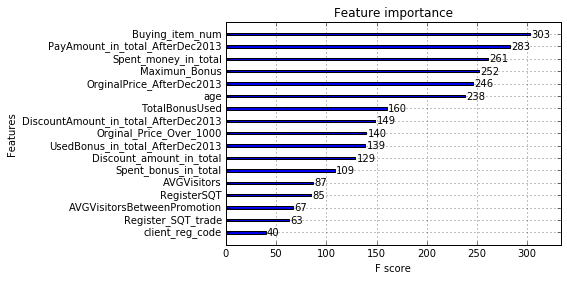

In [247]:
%matplotlib inline

plot_importance(clf.best_estimator_)

#xgboost.plot_tree(clf.best_estimator_)

plt.show()

In [259]:
#Split the dataset into X, and Y
Y = dataset["label"]
X = dataset.drop("label",1)
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [184]:
dataset_new = pd.read_csv('Default_dataset_without_preprocess.csv')

In [260]:
parameter_Grid_search = {
    'max_delta_step'  : [3],
}

clf = GridSearchCV(estimator = xgboost.XGBClassifier(
        n_estimators = 400,
        learning_rate = 0.1,
        scale_pos_weight = 8,
        subsample = 0.7,
        min_child_weight = 1,
        max_depth = 3
        
                                                    #max_delta_step = 2,
                                                    #scale_pos_weight = 16,
                                                    #gamma = 0.4,
                                                    #colsample_bytree = 0.8,
                                                    #subsample = 0.9,
                                                    #reg_alpha = 100
    ), scoring = 'neg_log_loss', param_grid = parameter_Grid_search, cv = 5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=400, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=8, seed=0, silent=True, subsample=0.7),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_delta_step': [3]}, pre_dispatch='2*n_jobs',
       refit=True, scoring='neg_log_loss', verbose=0)

([mean: -0.25868, std: 0.00099, params: {'max_delta_step': 3}],
 {'max_delta_step': 3},
 -0.2586756084056884)

In [272]:
print(clf.grid_scores_, clf.best_params_, clf.best_score_)

y_true, y_pred = y_test, clf.predict(X_test)

estimator = clf.best_estimator_
probs = estimator.predict_proba(X_test)

print(classification_report(y_true, y_pred))

print("f1_score: %.2f%%" % (metrics.f1_score(y_test, y_pred, pos_label = 1, average = 'weighted') * 100.0))

print("roc_auc_score: %.2f%%" % (metrics.roc_auc_score(y_test, probs[:, 1]) * 100.00))

print("accuracy_score: %.2f%%" % (metrics.accuracy_score(y_test, y_pred) * 100.00))

print("cohen_kappa_score: %.2f" % (metrics.cohen_kappa_score(y_test, y_pred)))

print(metrics.confusion_matrix(y_test, y_pred)) 

print(clf.best_estimator_.booster().get_fscore())

[mean: -0.25880, std: 0.00080, params: {'max_delta_step': 3}] {'max_delta_step': 3} -0.2587967652808196
             precision    recall  f1-score   support

          0       0.97      0.94      0.95    205563
          1       0.14      0.28      0.19      7727

avg / total       0.94      0.91      0.93    213290

f1_score: 92.69%
roc_auc_score: 80.48%
accuracy_score: 91.41%
cohen_kappa_score: 0.15
[[192803  12760]
 [  5570   2157]]
{'Spent_bonus_in_total': 120, 'Register_SQT_trade': 56, 'Buying_item_num': 333, 'client_reg_code': 55, 'DiscountAmount_in_total_AfterDec2013': 161, 'Spent_money_in_total': 218, 'age': 238, 'AVGVisitors': 101, 'TotalBonusUsed': 154, 'Orginal_Price_Over_1000': 109, 'Discount_amount_in_total': 124, 'PayAmount_in_total_AfterDec2013': 248, 'OrginalPrice_AfterDec2013': 253, 'AVGVisitorsBetweenPromotion': 58, 'RegisterSQT': 89, 'UsedBonus_in_total_AfterDec2013': 179, 'Maximun_Bonus': 239}


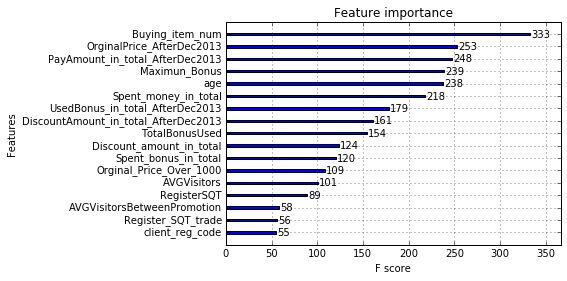

In [264]:
%matplotlib inline

plot_importance(clf.best_estimator_)

#xgboost.plot_tree(clf.best_estimator_)

plt.show()

In [131]:
# Fit model using each importance as a threshold
from numpy import sort
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
thresholds = sort(estimator.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(estimator, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = xgboost.XGBClassifier(
        n_estimators = 400,
        learning_rate = 0.1,
        scale_pos_weight = 8,
        subsample = 0.7,
        min_child_weight = 1,
        max_depth = 3
        
                                                    #max_delta_step = 2,
                                                    #scale_pos_weight = 16,
                                                    #gamma = 0.4,
                                                    #colsample_bytree = 0.8,
                                                    #subsample = 0.9,
                                                    #reg_alpha = 100
    )
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    probs = selection_model.predict_proba(select_X_test)
    roc_auc_score = metrics.roc_auc_score(y_test, probs[:, 1])
    f1_score = metrics.f1_score(y_test, predictions, pos_label = 1, average = 'weighted')
    accuracy = accuracy_score(y_test, predictions)
    
    print("Thresh=%.3f, n=%d, f1_score: %.2f%%" % (thresh, select_X_train.shape[1], f1_score * 100.0))
    print("Thresh=%.3f, n=%d, roc_auc_score: %.2f%%" % (thresh, select_X_train.shape[1], roc_auc_score * 100.00))
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy * 100.0))


Thresh=0.000, n=25, f1_score: 92.71%
Thresh=0.000, n=25, roc_auc_score: 80.98%
Thresh=0.000, n=25, Accuracy: 91.51%
Thresh=0.000, n=25, f1_score: 92.71%
Thresh=0.000, n=25, roc_auc_score: 80.98%
Thresh=0.000, n=25, Accuracy: 91.51%
Thresh=0.001, n=23, f1_score: 92.71%
Thresh=0.001, n=23, roc_auc_score: 80.94%
Thresh=0.001, n=23, Accuracy: 91.50%
Thresh=0.003, n=22, f1_score: 92.72%
Thresh=0.003, n=22, roc_auc_score: 80.94%
Thresh=0.003, n=22, Accuracy: 91.53%
Thresh=0.003, n=21, f1_score: 92.72%
Thresh=0.003, n=21, roc_auc_score: 80.94%
Thresh=0.003, n=21, Accuracy: 91.52%
Thresh=0.007, n=20, f1_score: 92.73%
Thresh=0.007, n=20, roc_auc_score: 80.99%
Thresh=0.007, n=20, Accuracy: 91.54%
Thresh=0.007, n=20, f1_score: 92.73%
Thresh=0.007, n=20, roc_auc_score: 80.99%
Thresh=0.007, n=20, Accuracy: 91.54%
Thresh=0.010, n=18, f1_score: 92.71%
Thresh=0.010, n=18, roc_auc_score: 80.91%
Thresh=0.010, n=18, Accuracy: 91.51%
Thresh=0.017, n=17, f1_score: 92.68%
Thresh=0.017, n=17, roc_auc_score: 